In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import re
import shutil
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import PIL.Image as Image
from keras.applications import ResNet50V2 
import lime
from keras.applications.imagenet_utils import decode_predictions
from lime import lime_image
from skimage.segmentation import mark_boundaries
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv("data/Crash_data.csv")

In [3]:
df

,OID,PrmaryCollsionType,CaseNumber,UnitsInvolved,CrossStreet,StreetType,DirectionFromIntersection,FeetFromIntersection,CollisionDate,ReportedDate,...,Lon,DUI,AlcoholDrugSuspected,BicyclesInvolved,PedestriansInvolved,RoadDescription,Crash_Time,ESRI_OID,x,y
0,4931,COLLISION W/ MV - FRONT TO REAR,1904154,2,S. BOULDER RD/MANHATTAN CIR.,CITY ST/CNTY RD,W,NaN,4/18/2019 6:00:00 AM,4/18/2019 6:00:00 AM,...,-105.227477,NO,NO,NO,NO,INTERSECTION RELATED,1228,106,-105.227477,39.985895
1,10847,COLLISION W/ MV - FRONT TO REAR,2206289,2,26TH ST/CANYON BLVD,CITY ST/CNTY RD,N,100,7/3/2022 6:00:00 AM,7/3/2022 6:00:00 AM,...,-105.260463,NO,NO,NO,NO,NON-INTERSECTION,1830,107,-105.260463,40.017486
2,11727,COLLISION W/ MV - FRONT TO REAR,2212629,2,ARAPAHOE AVE,OTHER RDWY,,NaN,12/25/2022 7:00:00 AM,12/25/2022 7:00:00 AM,...,-105.263361,NO,NO,NO,NO,NaN,1614,108,-105.263361,40.014816
3,12855,COLLISION W/ MV - FRONT TO SIDE,2307980,2,MOORHEAD AVENUE,NaN,,NaN,8/15/2023 6:00:00 AM,8/17/2023 6:00:00 AM,...,-105.259824,NO,NO,NO,NO,PARKING LOT,2045,109,-105.259824,39.998445
4,12888,COLLISION W/ MV - FRONT TO SIDE,2308220,2,28TH STREET/MAPLETON AVE,STATE HWY,,NaN,8/23/2023 6:00:00 AM,8/23/2023 6:00:00 AM,...,-105.258383,NO,NO,NO,NO,AT INTERSECTION,1330,110,-105.258383,40.025511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13292,8597,COLLISION W/ OBJECT,1,3,,,,,4/12/2021 6:00:00 AM,4/12/2021 6:00:00 AM,...,NaN,NO,NO,NO,NO,EXPRESS/MANAGED/HOV LANE,0900,13447,NaN,NaN
13293,10080,COLLISION W/ OTHER VEH - PARKED MV,2200754,2,CASCADE AVE/20TH ST,CITY ST/CNTY RD,W,96,1/25/2022 7:00:00 AM,1/25/2022 7:00:00 AM,...,-105.267770,NO,NO,NO,NO,ALLEY RELATED,0744,13448,-105.267770,40.001851
13294,12011,COLLISION W/ MV - FRONT TO REAR,2301807,2,CANYON BLVD/28TH ST,STATE HWY,,NaN,2/23/2023 7:00:00 AM,2/23/2023 7:00:00 AM,...,-105.258456,NO,NO,NO,NO,AT INTERSECTION,2050,13449,-105.258456,40.017347
13295,11984,COLLISION W/ MV - FRONT TO SIDE,2301556,2,TABLE MESA DRIVE/S LOOP DRIVE,CITY ST/CNTY RD,,NaN,2/15/2023 7:00:00 AM,2/17/2023 7:00:00 AM,...,-105.234551,NO,NO,NO,NO,AT INTERSECTION,2225,13450,-105.235069,39.986390


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13297 entries, 0 to 13296
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OID                        13297 non-null  int64  
 1   PrmaryCollsionType         13297 non-null  object 
 2   CaseNumber                 13297 non-null  int64  
 3   UnitsInvolved              13297 non-null  int64  
 4   CrossStreet                13290 non-null  object 
 5   StreetType                 11526 non-null  object 
 6   DirectionFromIntersection  13297 non-null  object 
 7   FeetFromIntersection       2628 non-null   object 
 8   CollisionDate              13297 non-null  object 
 9   ReportedDate               13296 non-null  object 
 10  ReportedYear               13296 non-null  float64
 11  ReportedMonth              13296 non-null  float64
 12  ReportedMonthName          13296 non-null  object 
 13  ReportedWeek               13296 non-null  flo

In [5]:
df.describe()

,OID,CaseNumber,UnitsInvolved,ReportedYear,ReportedMonth,ReportedWeek,ReportedDayofWeekNum,ReportedDayofMonth,ReportedHour,NumKilled,NumSeriouslyInjured,NumInjuredOrKilled,Lat,Lon,ESRI_OID,x,y
count,13297.000000,1.329700e+04,13297.000000,13296.000000,13296.00000,13296.000000,13296.000000,13296.000000,13296.000000,13297.000000,13297.000000,13297.000000,12026.000000,12026.000000,13297.000000,12026.000000,12026.000000
mean,6775.936527,1.995658e+06,2.000451,2019.881242,6.87500,13.096495,4.174789,15.601233,13.096495,0.001579,0.027224,0.116643,40.015781,-105.257787,6782.565391,-105.257788,40.015782
std,3867.639926,1.947099e+05,0.592649,1.928615,3.39564,5.050458,1.811704,8.787234,5.050458,0.043333,0.168197,0.357582,0.017732,0.018141,3845.066097,0.018140,0.017731
min,1.000000,1.000000e+00,1.000000,2017.000000,1.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,39.964537,-105.297895,106.000000,-105.297895,39.964537
25%,3439.000000,1.812492e+06,2.000000,2018.000000,4.00000,10.000000,3.000000,8.000000,10.000000,0.000000,0.000000,0.000000,40.005172,-105.272693,3457.000000,-105.272693,40.005172
50%,6792.000000,2.000175e+06,2.000000,2020.000000,7.00000,13.000000,4.000000,16.000000,13.000000,0.000000,0.000000,0.000000,40.014866,-105.258401,6781.000000,-105.258401,40.014866
75%,10124.000000,2.200915e+06,2.000000,2022.000000,10.00000,16.000000,6.000000,23.000000,16.000000,0.000000,0.000000,0.000000,40.023419,-105.248252,10105.000000,-105.248252,40.023419
max,13451.000000,2.373985e+06,44.000000,2023.000000,12.00000,23.000000,7.000000,31.000000,23.000000,2.000000,3.000000,4.000000,40.094401,-105.178496,13451.000000,-105.178496,40.094401


In [6]:
df.isnull().sum()

OID                              0
PrmaryCollsionType               0
CaseNumber                       0
UnitsInvolved                    0
CrossStreet                      7
StreetType                    1771
DirectionFromIntersection        0
FeetFromIntersection         10669
CollisionDate                    0
ReportedDate                     1
ReportedYear                     1
ReportedMonth                    1
ReportedMonthName                1
ReportedWeek                     1
ReportedDayofWeekNum             1
ReportedDayofMonth               1
ReportedDayofWeek                1
ReportedHour                     1
HitAndRunStatus                  0
LightingCondition              172
RoadCondition                  617
WeatherCondition                40
Severity                         0
NumKilled                        0
NumSeriouslyInjured              0
NumInjuredOrKilled               0
Lat                           1271
Lon                           1271
DUI                 

In [7]:
df.drop(["StreetType", "DirectionFromIntersection", "FeetFromIntersection", 
         "x", "y", "ESRI_OID", "UnitsInvolved", "ReportedDate"], axis=1, inplace=True)
df

,OID,PrmaryCollsionType,CaseNumber,CrossStreet,CollisionDate,ReportedDate,ReportedYear,ReportedMonth,ReportedMonthName,ReportedWeek,...,NumSeriouslyInjured,NumInjuredOrKilled,Lat,Lon,DUI,AlcoholDrugSuspected,BicyclesInvolved,PedestriansInvolved,RoadDescription,Crash_Time
0,4931,COLLISION W/ MV - FRONT TO REAR,1904154,S. BOULDER RD/MANHATTAN CIR.,4/18/2019 6:00:00 AM,4/18/2019 6:00:00 AM,2019.0,4.0,April,15.0,...,0,0,39.985895,-105.227477,NO,NO,NO,NO,INTERSECTION RELATED,1228
1,10847,COLLISION W/ MV - FRONT TO REAR,2206289,26TH ST/CANYON BLVD,7/3/2022 6:00:00 AM,7/3/2022 6:00:00 AM,2022.0,7.0,July,20.0,...,0,0,40.017486,-105.260463,NO,NO,NO,NO,NON-INTERSECTION,1830
2,11727,COLLISION W/ MV - FRONT TO REAR,2212629,ARAPAHOE AVE,12/25/2022 7:00:00 AM,12/25/2022 7:00:00 AM,2022.0,12.0,December,17.0,...,0,0,40.014816,-105.263361,NO,NO,NO,NO,NaN,1614
3,12855,COLLISION W/ MV - FRONT TO SIDE,2307980,MOORHEAD AVENUE,8/15/2023 6:00:00 AM,8/17/2023 6:00:00 AM,2023.0,8.0,August,14.0,...,0,0,39.998445,-105.259824,NO,NO,NO,NO,PARKING LOT,2045
4,12888,COLLISION W/ MV - FRONT TO SIDE,2308220,28TH STREET/MAPLETON AVE,8/23/2023 6:00:00 AM,8/23/2023 6:00:00 AM,2023.0,8.0,August,8.0,...,0,0,40.025511,-105.258383,NO,NO,NO,NO,AT INTERSECTION,1330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13292,8597,COLLISION W/ OBJECT,1,,4/12/2021 6:00:00 AM,4/12/2021 6:00:00 AM,2021.0,4.0,April,0.0,...,0,0,NaN,NaN,NO,NO,NO,NO,EXPRESS/MANAGED/HOV LANE,0900
13293,10080,COLLISION W/ OTHER VEH - PARKED MV,2200754,CASCADE AVE/20TH ST,1/25/2022 7:00:00 AM,1/25/2022 7:00:00 AM,2022.0,1.0,January,16.0,...,0,0,40.001851,-105.267770,NO,NO,NO,NO,ALLEY RELATED,0744
13294,12011,COLLISION W/ MV - FRONT TO REAR,2301807,CANYON BLVD/28TH ST,2/23/2023 7:00:00 AM,2/23/2023 7:00:00 AM,2023.0,2.0,February,23.0,...,0,0,40.017347,-105.258456,NO,NO,NO,NO,AT INTERSECTION,2050
13295,11984,COLLISION W/ MV - FRONT TO SIDE,2301556,TABLE MESA DRIVE/S LOOP DRIVE,2/15/2023 7:00:00 AM,2/17/2023 7:00:00 AM,2023.0,2.0,February,0.0,...,0,0,39.986458,-105.234551,NO,NO,NO,NO,AT INTERSECTION,2225


In [8]:
df.corr()

,OID,CaseNumber,ReportedYear,ReportedMonth,ReportedWeek,ReportedDayofWeekNum,ReportedDayofMonth,ReportedHour,NumKilled,NumSeriouslyInjured,NumInjuredOrKilled,Lat,Lon
OID,1.000000,0.966156,0.983789,-0.026637,0.002398,0.018791,0.004948,0.002398,0.014067,0.021036,0.063212,0.006294,-0.002130
CaseNumber,0.966156,1.000000,0.978638,-0.137971,0.003844,0.023461,-0.000267,0.003844,-0.005979,0.020685,0.058564,0.008573,-0.001623
ReportedYear,0.983789,0.978638,1.000000,-0.165991,0.001362,0.019697,0.000286,0.001362,0.013944,0.020634,0.061423,0.008245,-0.001088
ReportedMonth,-0.026637,-0.137971,-0.165991,1.000000,0.006677,-0.006352,-0.031270,0.006677,-0.002747,0.009910,0.023035,-0.008503,-0.001506
ReportedWeek,0.002398,0.003844,0.001362,0.006677,1.000000,0.043056,-0.021320,1.000000,-0.011007,-0.010265,-0.000527,0.008507,-0.022476
ReportedDayofWeekNum,0.018791,0.023461,0.019697,-0.006352,0.043056,1.000000,-0.001286,0.043056,-0.006391,-0.006979,-0.027295,-0.010498,0.000003
ReportedDayofMonth,0.004948,-0.000267,0.000286,-0.031270,-0.021320,-0.001286,1.000000,-0.021320,0.016073,0.017269,0.008701,-0.001822,-0.007536
ReportedHour,0.002398,0.003844,0.001362,0.006677,1.000000,0.043056,-0.021320,1.000000,-0.011007,-0.010265,-0.000527,0.008507,-0.022476
NumKilled,0.014067,-0.005979,0.013944,-0.002747,-0.011007,-0.006391,0.016073,-0.011007,1.000000,0.035377,0.148286,0.014476,0.014368
NumSeriouslyInjured,0.021036,0.020685,0.020634,0.009910,-0.010265,-0.006979,0.017269,-0.010265,0.035377,1.000000,0.488668,0.005997,0.015759


In [9]:
df['BicyclesInvolved'].value_counts()

NO     12588
YES      709
Name: BicyclesInvolved, dtype: int64

In [10]:
bicycles = df[df['BicyclesInvolved'] == "YES"]
bicycles

,OID,PrmaryCollsionType,CaseNumber,CrossStreet,CollisionDate,ReportedDate,ReportedYear,ReportedMonth,ReportedMonthName,ReportedWeek,...,NumSeriouslyInjured,NumInjuredOrKilled,Lat,Lon,DUI,AlcoholDrugSuspected,BicyclesInvolved,PedestriansInvolved,RoadDescription,Crash_Time
5,11080,COLLISION W/ MV - FRONT TO SIDE,2208096,28TH FRONTAGE RD/AURORA AVE,8/20/2022 6:00:00 AM,8/21/2022 6:00:00 AM,2022.0,8.0,August,17.0,...,0,1,40.004893,-105.258579,NO,NO,YES,NO,DRIVEWAY ACCESS RELATED,1615
36,12301,COLLISION W/ OTHER VEH - BICYCLE,2304143,PLEASANT ST./11TH ST.,5/3/2023 6:00:00 AM,5/3/2023 6:00:00 AM,2023.0,5.0,May,21.0,...,0,0,40.009451,-105.278667,NO,NO,YES,NO,NaN,2155
56,5694,COLLISION W/ OBJECT,1908872,PEARL PKWY/49TH ST,8/7/2019 6:00:00 AM,8/8/2019 6:00:00 AM,2019.0,8.0,August,19.0,...,1,1,40.021976,-105.238467,NO,NO,YES,NO,NON-INTERSECTION,2128
332,188,COLLISION W/ OBJECT,1710316,FOOTHILLS PKWY/VALMONT RD,8/14/2017 6:00:00 AM,8/14/2017 6:00:00 AM,2017.0,8.0,August,12.0,...,0,1,NaN,NaN,NO,NO,YES,NO,NON-INTERSECTION,1000
355,7014,COLLISION W/ OBJECT,2001687,FOOTHILLS PKWY/TABLE MESA,2/14/2020 7:00:00 AM,2/14/2020 7:00:00 AM,2020.0,2.0,February,15.0,...,0,0,40.017687,-105.250702,NO,NO,YES,NO,NON-INTERSECTION,1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13072,11533,COLLISION W/ OTHER VEH - BICYCLE,2211377,BASELINE RD/CANYON CREEK,11/14/2022 7:00:00 AM,11/14/2022 7:00:00 AM,2022.0,11.0,November,20.0,...,0,1,39.999949,-105.254450,NO,NO,YES,NO,AT INTERSECTION,1522
13073,9859,COLLISION W/ OTHER VEH - BICYCLE,2111686,ALPINE AVE/6TH ST,12/7/2021 7:00:00 AM,12/7/2021 7:00:00 AM,2021.0,12.0,December,14.0,...,0,1,40.025520,-105.288730,NO,NO,YES,NO,AT INTERSECTION,1534
13074,9501,COLLISION W/ OTHER VEH - BICYCLE,2109296,13TH STREET/HIGH SREET,9/30/2021 6:00:00 AM,9/30/2021 6:00:00 AM,2021.0,9.0,September,9.0,...,0,0,40.022453,-105.280127,NO,NO,YES,NO,AT INTERSECTION,0843
13077,8984,COLLISION W/ OTHER VEH - BICYCLE,2105628,30TH STREET/ARAPAHOE AVENUE,7/1/2021 6:00:00 AM,7/1/2021 6:00:00 AM,2021.0,7.0,July,7.0,...,1,1,40.014563,-105.253686,NO,NO,YES,NO,AT INTERSECTION,1522


In [11]:
bicycles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709 entries, 5 to 13296
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   OID                   709 non-null    int64  
 1   PrmaryCollsionType    709 non-null    object 
 2   CaseNumber            709 non-null    int64  
 3   CrossStreet           709 non-null    object 
 4   CollisionDate         709 non-null    object 
 5   ReportedDate          709 non-null    object 
 6   ReportedYear          709 non-null    float64
 7   ReportedMonth         709 non-null    float64
 8   ReportedMonthName     709 non-null    object 
 9   ReportedWeek          709 non-null    float64
 10  ReportedDayofWeekNum  709 non-null    float64
 11  ReportedDayofMonth    709 non-null    float64
 12  ReportedDayofWeek     709 non-null    object 
 13  ReportedHour          709 non-null    float64
 14  HitAndRunStatus       709 non-null    object 
 15  LightingCondition    

In [12]:
bicycles.corr()

,OID,CaseNumber,ReportedYear,ReportedMonth,ReportedWeek,ReportedDayofWeekNum,ReportedDayofMonth,ReportedHour,NumKilled,NumSeriouslyInjured,NumInjuredOrKilled,Lat,Lon
OID,1.000000,0.911989,0.986983,-0.056689,0.082082,-0.002400,-0.015566,0.082082,0.017565,0.061591,0.112622,-0.017808,0.032566
CaseNumber,0.911989,1.000000,0.917948,-0.110122,0.121139,0.001508,-0.038239,0.121139,-0.175586,0.063185,0.106001,-0.003377,0.047098
ReportedYear,0.986983,0.917948,1.000000,-0.165152,0.085162,-0.007206,-0.020609,0.085162,0.024386,0.060773,0.126328,-0.001705,0.048393
ReportedMonth,-0.056689,-0.110122,-0.165152,1.000000,-0.061632,-0.026844,-0.040540,-0.061632,-0.065628,0.001972,-0.073437,-0.047743,-0.057629
ReportedWeek,0.082082,0.121139,0.085162,-0.061632,1.000000,0.032678,-0.087563,1.000000,-0.069382,-0.038954,0.038954,-0.002687,0.016346
ReportedDayofWeekNum,-0.002400,0.001508,-0.007206,-0.026844,0.032678,1.000000,-0.031672,0.032678,-0.006658,-0.027204,-0.051945,-0.061023,-0.042102
ReportedDayofMonth,-0.015566,-0.038239,-0.020609,-0.040540,-0.087563,-0.031672,1.000000,-0.087563,0.045855,-0.035821,0.014417,0.018300,0.013308
ReportedHour,0.082082,0.121139,0.085162,-0.061632,1.000000,0.032678,-0.087563,1.000000,-0.069382,-0.038954,0.038954,-0.002687,0.016346
NumKilled,0.017565,-0.175586,0.024386,-0.065628,-0.069382,-0.006658,0.045855,-0.069382,1.000000,-0.032330,0.057810,0.071654,0.111405
NumSeriouslyInjured,0.061591,0.063185,0.060773,0.001972,-0.038954,-0.027204,-0.035821,-0.038954,-0.032330,1.000000,0.426607,0.066738,0.006860


In [38]:
bicycles["ReportedMonthName"].value_counts()

August       109
September    109
October       86
November      74
June          61
May           52
July          51
December      45
April         39
January       32
March         29
February      22
Name: ReportedMonthName, dtype: int64

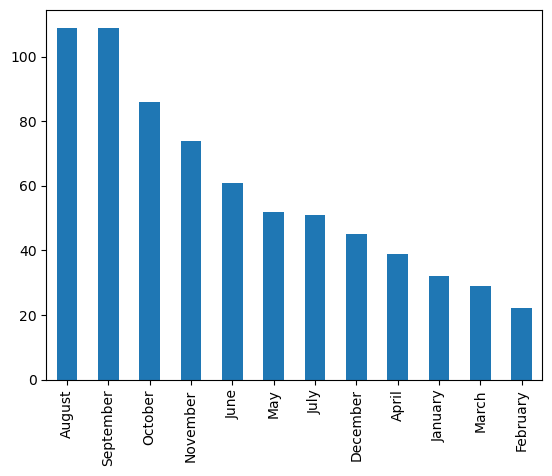

In [56]:
bicycles["ReportedMonthName"].value_counts().plot(kind='bar');

In [71]:
bicycles["NumKilled"].value_counts()

0    705
1      4
Name: NumKilled, dtype: int64

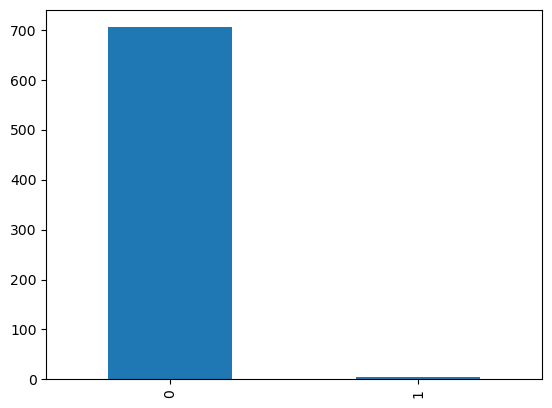

In [62]:
bicycles["NumKilled"].value_counts().plot(kind="bar");

In [68]:
bicycles["ReportedYear"].value_counts()

2018.0    153
2019.0    145
2017.0    106
2023.0     97
2020.0     73
2021.0     71
2022.0     64
Name: ReportedYear, dtype: int64

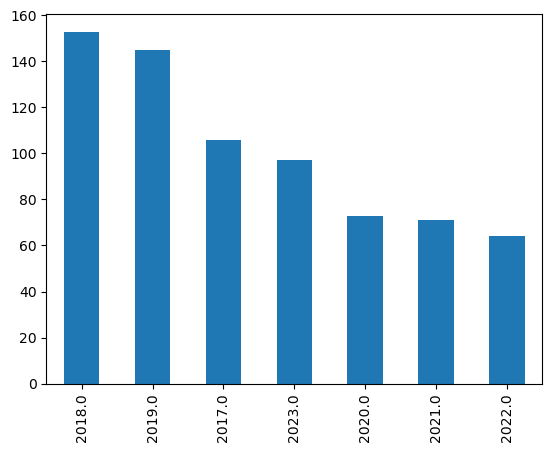

In [67]:
bicycles["ReportedYear"].value_counts().plot(kind='bar');
#order=bicycles["ReportedYear"].sort_values()

In [70]:
bicycles["ReportedHour"].value_counts()

10.0    72
15.0    63
13.0    59
14.0    55
12.0    53
9.0     52
16.0    49
17.0    48
11.0    44
18.0    41
23.0    26
22.0    25
20.0    22
19.0    19
7.0     16
21.0    16
8.0     12
0.0     11
1.0      8
6.0      7
4.0      3
5.0      3
3.0      3
2.0      2
Name: ReportedHour, dtype: int64

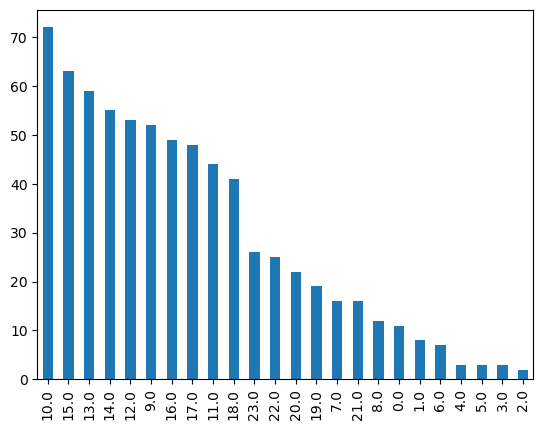

In [69]:
bicycles["ReportedHour"].value_counts().plot(kind="bar");

In [73]:
bicycles["RoadCondition"].value_counts()

DRY             657
WET              34
SNOWY/SLUSHY      7
ICY               3
Name: RoadCondition, dtype: int64

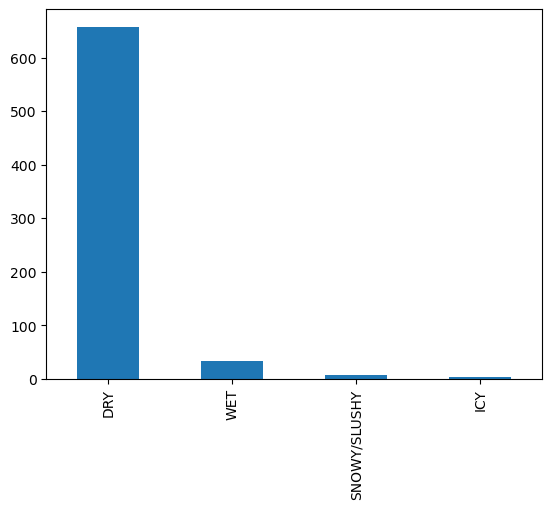

In [72]:
bicycles["RoadCondition"].value_counts().plot(kind="bar");

In [74]:
bicycles["WeatherCondition"].value_counts()

NONE               659
RAIN                24
SNOW/SLEET/HAIL      9
CLOUDY               9
WIND                 5
BLOWING SNOW         1
Name: WeatherCondition, dtype: int64

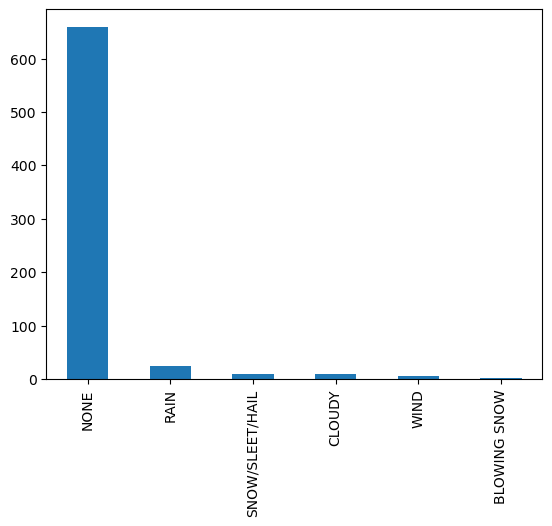

In [75]:
bicycles["WeatherCondition"].value_counts().plot(kind="bar");

In [76]:
bicycles["ReportedDayofWeekNum"].value_counts()

4.0    150
5.0    130
6.0    110
3.0    108
2.0     91
7.0     68
1.0     52
Name: ReportedDayofWeekNum, dtype: int64

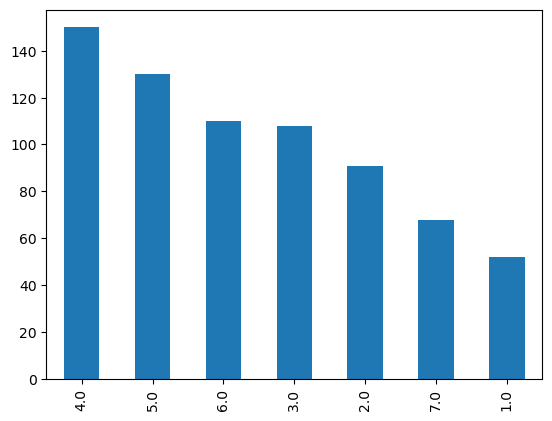

In [77]:
bicycles["ReportedDayofWeekNum"].value_counts().plot(kind="bar");

In [13]:
lat_lon = bicycles[["Lat", "Lon"]]
lat_lon.dropna(inplace=True)
lat_lon

,Lat,Lon
5,40.004893,-105.258579
36,40.009451,-105.278667
56,40.021976,-105.238467
355,40.017687,-105.250702
522,40.055976,-105.282194
...,...,...
13071,40.029246,-105.290297
13072,39.999949,-105.254450
13073,40.025520,-105.288730
13074,40.022453,-105.280127


In [14]:
# get lat and long of zipcodes


import folium
#create map
m = folium.Map(
    location=[40.00054,-105.1614],
    width='75%',
    length='75%',
    zoom_start=9.5
)

# add markers for each location
for a in list(range(len(lat_lon))):
    
    folium.Circle(
    radius=10,
    location=[lat_lon[['Lat','Lon']].iloc[a][0],lat_lon[['Lat','Lon']].iloc[a][1]],
    #popup=str(lat_lon['ZipCode'].iloc[a]),
    color="crimson",
    fill=True,
    #icon=folium.Icon(icon=str(lat_lon['ZipCode'].iloc[a])),
    ).add_to(m);

m